<a href="https://colab.research.google.com/github/ShriyaRavikumar/Gender-and-Emotion-Recognition-by-Voice/blob/main/gender_and_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
from tqdm import tqdm

In [ ]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


In [ ]:
![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

--2023-05-06 06:35:09--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  9.08MB/s    in 30s     

2023-05-06 06:35:40 (6.56 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [ ]:
![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"

Archive:  Audio_Speech_Actors_01-24.zip
   creating: ./Audio_Speech_Actors_01-24/Actor_01/
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-

In [ ]:
import os
import pandas as pd

RAV = "./Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

neutral     288
happy       192
sad         192
disgust     192
angry       192
surprise    192
fear        192
Name: emotion, dtype: int64

In [ ]:
RAV_df

,gender,emotion,labels,source,path
0,male,neutral,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-02-...
1,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-03-...
2,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
3,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
4,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
...,...,...,...,...,...
1435,female,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-06-...
1436,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-08-...
1437,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-04-...
1438,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-03-...


In [ ]:
RAV_df = RAV_df[(RAV_df["emotion"]=="neutral") | (RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]

In [ ]:
train_df = RAV_df.sample(frac=0.8)
test_df = RAV_df.drop(train_df.index)

In [ ]:
train_df

,gender,emotion,labels,source,path
190,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_04/03-01-05-...
1039,female,neutral,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-02-...
1119,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_19/03-01-01-...
1186,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_20/03-01-04-...
274,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-04-...
...,...,...,...,...,...
926,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_16/03-01-04-...
1394,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-04-...
566,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_10/03-01-04-...
520,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_09/03-01-04-...


In [ ]:
train_df["emotion"].value_counts()

neutral    233
happy      162
angry      148
sad        148
Name: emotion, dtype: int64

In [ ]:
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                female
emotion                                                angry
labels                                                     5
source                                               RAVDESS
path       ./Audio_Speech_Actors_01-24/Actor_04/03-01-05-...
Name: 190, dtype: object


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.7 MB/s eta 0:00:00


In [ ]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

In [ ]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [ ]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

In [ ]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 2

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/2


100%|██████████| 346/346 [2:48:33<00:00, 29.23s/it, Loss=0.048, Accuracy=0.631]


Epoch 2/2


100%|██████████| 346/346 [2:44:26<00:00, 28.52s/it, Loss=0.040, Accuracy=0.738]


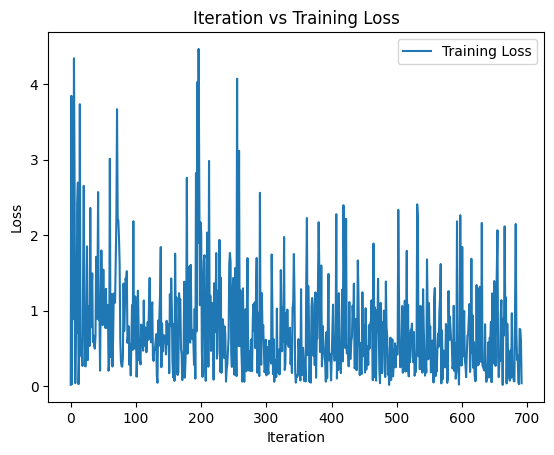

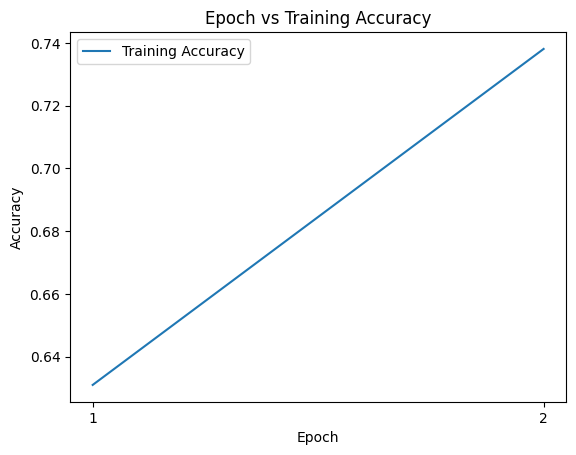

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

In [ ]:
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 173/173 [13:57<00:00,  4.84s/it, loss=3.558, accuracy=0.746]


The final accuracy on the test dataset: 74.5665%


In [ ]:
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]

,index,gender,emotion,labels,source,path,Model Prediction
0,3,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,neu
3,35,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,neu
7,52,male,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-03-...,neu
15,108,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_02/03-01-04-...,neu
16,113,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_02/03-01-04-...,neu
25,228,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_04/03-01-04-...,neu
30,254,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-04-...,neu
31,266,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-04-...,neu
34,294,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-04-...,neu
36,313,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06/03-01-04-...,neu


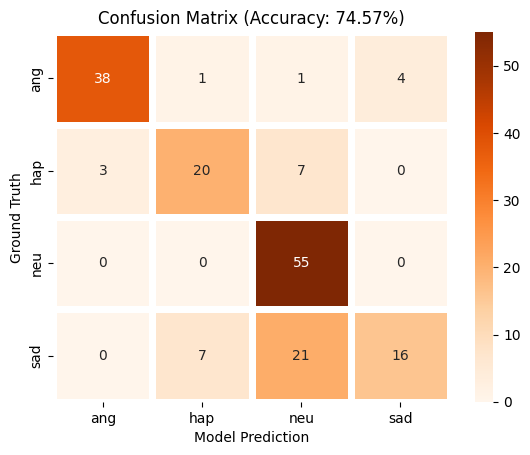

In [ ]:
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()